# Three-Period Interrupted Time Series Analysis

The three-period design extends standard interrupted time series to analyze **temporary interventions** with defined start and end times. By specifying `treatment_end_time`, the analysis splits the post-intervention period into:

- **Intervention period**: When treatment is active (from `treatment_time` to `treatment_end_time`)
- **Post-intervention period**: After treatment ends

This enables analysis of immediate effects, effect persistence, and decay patterns.

:::{note}
For standard two-period ITS analysis (permanent interventions), see {doc}`its_pymc`.
:::


In [53]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import causalpy as cp

In [54]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
seed = 42

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Example: Marketing Campaign

We simulate a 12-week marketing campaign with an immediate effect (+50 units) and partial persistence after it ends (+15 units, ~30% persistence).


In [55]:
# Set up simulation parameters
rng = np.random.default_rng(seed)
n_weeks = 135  # 2 years of weekly data
dates = pd.date_range(start="2022-06-01", end="2024-12-31", freq="W")

# Baseline: trend + seasonality + noise
trend = np.linspace(100, 120, n_weeks)
season = 10 * np.sin(2 * np.pi * np.arange(n_weeks) / 52)  # Annual seasonality
noise = rng.normal(0, 5, n_weeks)
baseline = trend + season + noise

# Add intervention effect
treatment_idx = n_weeks // 2  # Start at midpoint
treatment_end_idx = treatment_idx + 12  # 12 weeks duration

y = baseline.copy()
y[treatment_idx:treatment_end_idx] += 50  # During intervention
y[treatment_end_idx:] += 15  # Post-intervention (persistence)

# Create DataFrame
df = pd.DataFrame(
    {
        "y": y,
        "t": np.arange(n_weeks),
        "month": dates.month,
    },
    index=dates,
)

treatment_time = dates[treatment_idx]
treatment_end_time = dates[treatment_end_idx]

print(f"Treatment starts: {treatment_time}")
print(f"Treatment ends: {treatment_end_time}")
print(f"Intervention period: {treatment_end_idx - treatment_idx} weeks")
print(f"Post-intervention period: {n_weeks - treatment_end_idx} weeks")

Treatment starts: 2023-09-17 00:00:00
Treatment ends: 2023-12-10 00:00:00
Intervention period: 12 weeks
Post-intervention period: 56 weeks


## Run the Analysis

Specify `treatment_end_time` to enable three-period analysis:


In [56]:
result = cp.InterruptedTimeSeries(
    df,
    treatment_time=treatment_time,
    treatment_end_time=treatment_end_time,
    formula="y ~ 1 + t + C(month)",
    model=cp.pymc_models.LinearRegression(
        sample_kwargs={
            "random_seed": seed,
            "progressbar": False,
            "chains": 2,
            "draws": 1000,
        }
    ),
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, y_hat_sigma]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 46 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [beta, y_hat, y_hat_sigma]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


## Period-Specific Summaries

Get separate summaries for each period using the `period` parameter:


In [57]:
# Intervention period
intervention_summary = result.effect_summary(period="intervention")
print(intervention_summary.text)

During intervention (2023-09-17 00:00:00 to 2023-12-03 00:00:00), the average effect was 49.53 (95% HDI [45.86, 52.93]), with a posterior probability of an increase of 1.000. The cumulative effect was 594.37 (95% HDI [550.34, 635.19]); probability of an increase 1.000. Relative to the counterfactual, this equals 42.61% on average (95% HDI [38.22%, 46.87%]).


[autoreload of cutils_ext failed: Traceback (most recent call last):
  File "c:\Users\jeanv\miniconda3\envs\CausalPy\Lib\site-packages\IPython\extensions\autoreload.py", line 325, in check
    superreload(m, reload, self.old_objects)
    ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\jeanv\miniconda3\envs\CausalPy\Lib\site-packages\IPython\extensions\autoreload.py", line 580, in superreload
    module = reload(module)
  File "c:\Users\jeanv\miniconda3\envs\CausalPy\Lib\importlib\__init__.py", line 128, in reload
    raise ModuleNotFoundError(f"spec not found for the module {name!r}", name=name)
ModuleNotFoundError: spec not found for the module 'cutils_ext'
]


In [58]:
# Post-intervention period
post_summary = result.effect_summary(period="post")
print(post_summary.text)

Post-intervention (2023-12-10 00:00:00 to 2024-12-29 00:00:00), the average effect was 13.38 (95% HDI [9.32, 17.77]), with a posterior probability of an increase of 1.000. The cumulative effect was 749.26 (95% HDI [521.70, 994.98]); probability of an increase 1.000. Relative to the counterfactual, this equals 11.55% on average (95% HDI [7.50%, 15.64%]).


## Comparison Summary

Use `period='comparison'` to get a comparative summary showing persistence metrics:


The three-period design visualization adds a vertical line to mark where the treatment ends:

- **Solid red line**: `treatment_time` (intervention start)
- **Dashed orange line**: `treatment_end_time` (intervention end)

The plot shows three panels:
1. **Top panel**: Time series with observations, counterfactual predictions, and causal impact shading
2. **Middle panel**: Pointwise causal impact over time
3. **Bottom panel**: Cumulative causal impact

The vertical line at `treatment_end_time` clearly separates the intervention period from the post-intervention period, allowing you to visually assess effect persistence and decay.



In [59]:
comparison_summary = result.effect_summary(period="comparison")
print(comparison_summary.text)

Effect persistence: The post-intervention effect (13.4, 95% HDI [9.3, 17.8]) was 27.0% of the intervention effect (49.5, 95% HDI [45.9, 52.9]), with a posterior probability of 1.00 that some effect persisted beyond the intervention period.


The comparison summary provides:
- Post-intervention effect as percentage of intervention effect
- Posterior probability that some effect persisted
- HDI interval comparison between periods


## Detailed Persistence Analysis

The `analyze_persistence()` method automatically prints and returns a detailed summary of effect persistence:


In [60]:
persistence = result.analyze_persistence()

# The method automatically prints results. Access the returned dictionary:
print("\nAccessing results programmatically:")
print(f"  Mean effect during: {persistence['mean_effect_during']:.2f}")
print(f"  Mean effect post: {persistence['mean_effect_post']:.2f}")
print(
    f"  Persistence ratio: {persistence['persistence_ratio']:.3f} ({persistence['persistence_ratio'] * 100:.1f}%)"
)
print(f"  Total effect during: {persistence['total_effect_during']:.2f}")
print(f"  Total effect post: {persistence['total_effect_post']:.2f}")

Effect Persistence Analysis

During intervention period:
  Mean effect: 49.53
  95% HDI: [45.86, 52.93]
  Total effect: 594.37

Post-intervention period:
  Mean effect: 13.38
  95% HDI: [9.32, 17.77]
  Total effect: 749.26

Persistence ratio: 0.270
  (27.0% of intervention effect persisted)

Accessing results programmatically:
  Mean effect during: 49.53
  Mean effect post: 13.38
  Persistence ratio: 0.270 (27.0%)
  Total effect during: 594.37
  Total effect post: 749.26


## Visualization


C:\Users\jeanv\AppData\Local\Temp\ipykernel_19044\4224462085.py:2: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


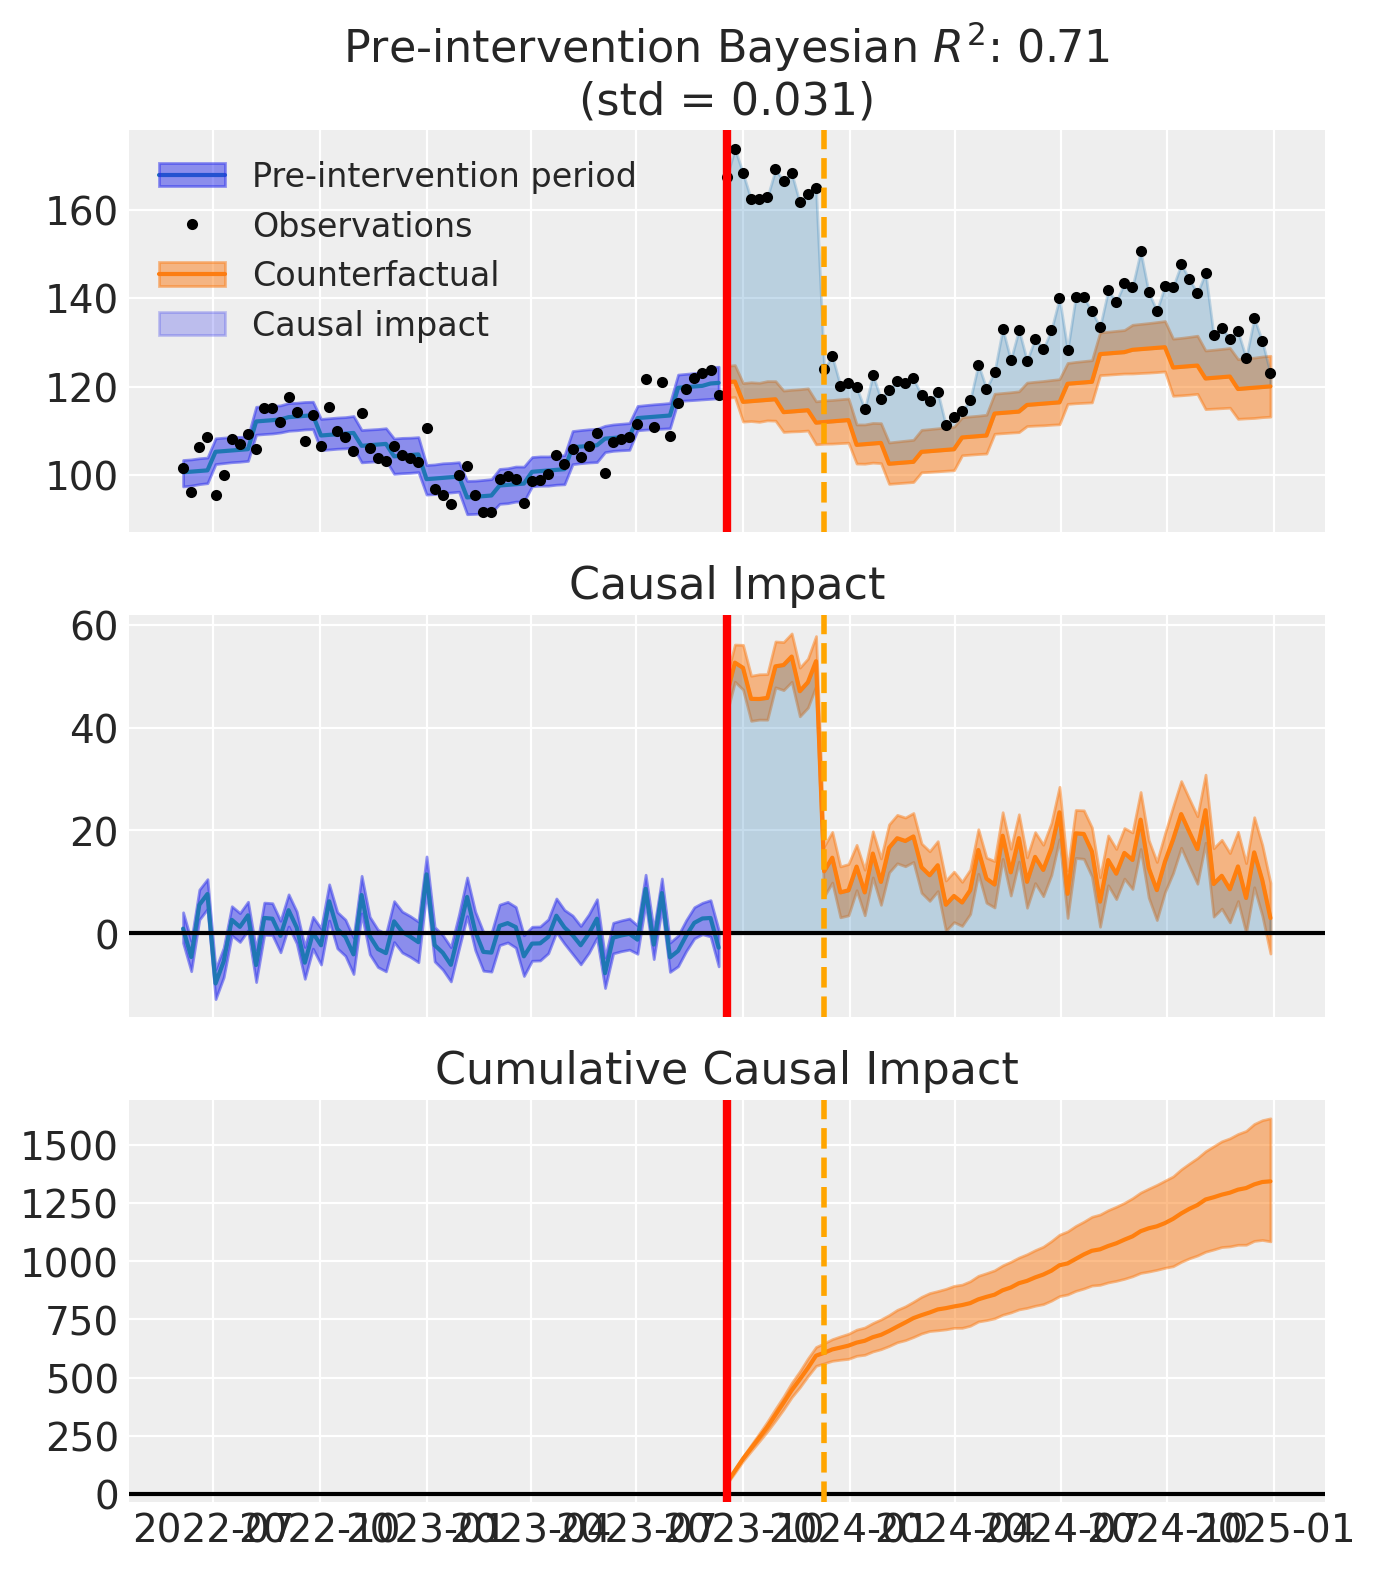

In [61]:
fig, ax = result.plot()
plt.tight_layout()
plt.show()

## Summary

The three-period design enables analysis of temporary interventions:

- **Immediate effects**: `effect_summary(period="intervention")` analyzes effects during the active intervention
- **Persistence**: `effect_summary(period="post")` measures how effects persist after the intervention ends
- **Comparison**: `effect_summary(period="comparison")` provides a comparative summary with persistence metrics
- **Detailed analysis**: `analyze_persistence()` automatically prints and returns a detailed summary with mean effects, persistence ratio (as decimal), and total effects

The persistence ratio (e.g., 0.30 = 30%) indicates how much of the intervention effect "carried over" into the post-intervention period. Note that the ratio can exceed 1.0 if the post-intervention effect is larger than the intervention effect.


## References

:::{bibliography}
:filter: docname in docnames
:::
